In [24]:
import itertools
import pandas as pd
from sqlalchemy import create_engine
import pymysql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import rc
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import sys, os, time
from glob import glob
warnings.filterwarnings(action='ignore')
mpl.rcParams['axes.unicode_minus'] = False
#font_path = 'C:/font/malgun.ttf'
#font_name = fm.FontProperties(fname=font_path).get_name()
#print(font_name)
rc('font', family='AppleGothic')

endpoint = 'dao.c51deksujiip.ap-northeast-2.rds.amazonaws.com'
schema = 'dao'
db_connection_str = 'mysql+pymysql://admin:ekfkawnl@{}/{}'.format(endpoint, schema)
try :
    db_connection = create_engine(db_connection_str)
    conn = db_connection.connect()
except :
    print('fail to connect db')

def load_data_from_rds(tabel_name):
    sql = "SELECT * FROM {}".format(tabel_name)
    df = pd.read_sql(sql, db_connection)
    return df

In [25]:
# sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(__file__))))

# from preprocessing.preprocessing_func import preprocess_df
def preprocess_df(df, onehot_col=None, scaling_col=None, drop_col = None, labeling_col = None, scaling_func=MinMaxScaler) :
    """
    :param df: 사용할 데이터프레임
    :param onehot_col: default = None, 원핫인코딩할 컬럼 리스트
    :param scaling_col: default = None, 스케일링할 컬럼 리스트
    :param drop_col: default = None, 사용하지 않을 컬럼 리스트
    :param labeling_col: default = None, 라벨링이 필요한 컬럼 리스트
    :param scaling_func: 스케일링시 사용할 컬럼, MinMaxScaler or StandardScaler
    :return: 전처리 된 데이터 프레임
    """
    if drop_col is not None :
        df = df.drop(drop_col, axis=1)
    if onehot_col is not None:
        df = pd.get_dummies(df, colums=onehot_col)
    if scaling_col is not None :
        for c in scaling_col :
            scaler = scaling_func()
            scaler.fit(df[[c]])
            df[c] = scaler.transform(df[[c]])
    if labeling_col is not None :
        for c in labeling_col :
            encoder = LabelEncoder()
            encoder.fit(df[c])
            df[c] = encoder.transform(df[c])
    return df



In [26]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [27]:
"""
n_estimators(혹은 num_boost_round) : 결정 트리의 개수
max_depth : 트리의 깊이
colsample_bytree : 컬럼의 샘플링 비율(random forest의 max_features와 비슷)
subsample : weak learner가 학습에 사용하는 데이터 샘플링 비율
learning_rate : 학습률
min_split_loss :  리프 노드를 추가적으로 나눌지 결정하는 값
reg_lambda : L2 규제
reg_alpha : L1 규제
"""
def xgboost_result(df, file_name, accuracy_li, f1_avg_li, feature_importance = False, optimizing = False):
    train_x, test_x, train_y, test_y = train_test_split(df.drop('생태통로_효율성', axis=1), df['생태통로_효율성'], test_size=0.2, stratify=df['생태통로_효율성'])
    xgb_clf = XGBClassifier()
    if optimizing :
        parameters = {
            'n_estimators': [10, 50, 100, 200, 300, 500],
            'learning_rate': [0.01, 0.001],
            'max_depth' : range(1, 10, 2),
            'min_split_loss' : range(1, 10, 1),
        }
        start = time.time()
        # Random Forest
        grid_cv = GridSearchCV(xgb_clf, param_grid=parameters, n_jobs=-1, scoring='accuracy', cv=5)
        grid_cv.fit(train_x, train_y)
        print('GridSearch 수행시간 : ', time.time()-start)
        print('최적 하이퍼 파라미터 :',grid_cv.best_params_)
        best_cv = grid_cv.best_estimator_

        # GridSearchCV의 최적 하이퍼파라미터로 학습된 Estimator로 예측 및 평가 수행
        pred = best_cv.predict(test_x)
        xgb_clf = best_cv
    else:
        xgb_clf.fit(train_x, train_y)
        pred = xgb_clf.predict(test_x)

    print('정확도 : ', accuracy_score(pred, test_y))
    print('f1 score :', f1_score(y_true=test_y, y_pred=pred, average=None))
    print('f1 score average :', f1_score(y_true=test_y, y_pred=pred, average='macro'))
    accuracy_li.append(accuracy_score(pred, test_y))
    f1_avg_li.append(f1_score(y_true=test_y, y_pred=pred, average='macro'))

    # 혼동행렬
    cm =confusion_matrix(test_y, pred)
    plot_confusion_matrix(cm, target_names=list(df['생태통로_효율성'].unique()), cmap='Blues', title='{} confusion matrix'.format(file_name))

    if feature_importance :
        importances = xgb_clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in xgb_clf.estimators_], axis=0)
        indices = np.argsort(importances)[::-1]

        print('Feature Ranking:')
        for f in range(train_x.shape[1]) :
            print('{}. feature {} ({:3f})'.format(f+1, train_x.columns[indices][f], importances[indices[f]]))
            if f == 10 :
                break

        plt.title('Feature importances')
        plt.bar(range(train_x.shape[1]), importances[indices],
                color='r', yerr=std[indices])
        plt.xlim([-1, train_x.shape[1]])
        plt.xticks(rotation=45)
        plt.show()
        
    return (accuracy_li, f1_avg_li)

In [28]:
overpass_list = glob('.././data/*overpass*.csv')
#overpass_list = [p.replace('\\', '/') for p in overpass_list]
print(overpass_list)
tunnel_list = glob('.././data/*tunnel*.csv')
#tunnel_list = [p.replace('\\', '/') for p in tunnel_list]
print(tunnel_list)

['.././data/overpass_knn2_median.csv', '.././data/overpass_mean_drop.csv', '.././data/overpass_knn1_drop.csv', '.././data/overpass_knn5_median.csv', '.././data/overpass_mean_median.csv', '.././data/overpass_knn3_median.csv', '.././data/overpass_knn2_drop.csv', '.././data/overpass_knn3_drop.csv', '.././data/overpass_knn5_drop.csv', '.././data/overpass_knn4_drop.csv', '.././data/overpass_knn4_median.csv', '.././data/overpass_knn1_median.csv']
['.././data/tunnel_knn1_drop.csv', '.././data/tunnel_mean_drop.csv', '.././data/tunnel_knn2_median.csv', '.././data/tunnel_knn5_median.csv', '.././data/tunnel_knn3_median.csv', '.././data/tunnel_knn2_drop.csv', '.././data/tunnel_knn3_drop.csv', '.././data/tunnel_mean_median.csv', '.././data/tunnel_knn1_median.csv', '.././data/tunnel_knn4_median.csv', '.././data/tunnel_knn5_drop.csv', '.././data/tunnel_knn4_drop.csv']


In [29]:
onehot_col = ['지형기호(2.3km)', '최우점식물군락']
scaling_col = ['폭(m)', '연장(m)', '주변 로드킬 빈도', '산책로까지의 최단 거리(km)', '농가까지의 거리(km)', '도로 최고제한속도(km/h)',
               '하천거리(km)', '주변 동물종 개수', '등산로까지 최단거리(km)', '유도울타리_연장_m', '유도울타리_높이_m', '교통량', 
               '건물까지거리(km)', '주변동물 출현빈도']
drop_col = ['번호', '위도', '경도', '생태통로_유형', '이용확인종_수', '유도울타리_위도_2.3km', '유도울타리_경도_2.3km', '식물군락명']
scaling_col_tunnel = scaling_col + ['높이(m)', '개방도']

# 육교형

GridSearch 수행시간 :  44.590636014938354
최적 하이퍼 파라미터 : {'learning_rate': 0.001, 'max_depth': 5, 'min_split_loss': 1, 'n_estimators': 10}
정확도 :  0.6166666666666667
f1 score : [0.4375     0.76470588 0.4       ]
f1 score average : 0.5340686274509804


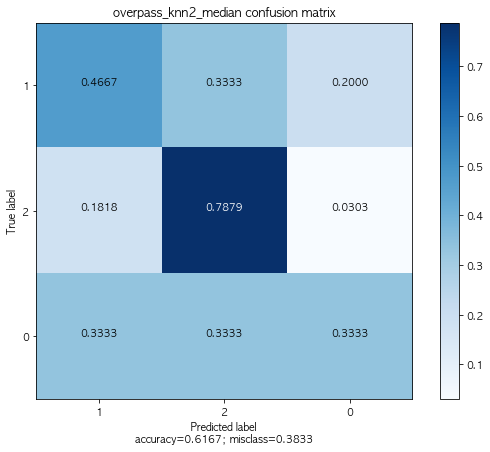

GridSearch 수행시간 :  38.25458312034607
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 3, 'min_split_loss': 1, 'n_estimators': 300}
정확도 :  0.32432432432432434
f1 score : [0.48648649 0.         0.24      ]
f1 score average : 0.24216216216216216


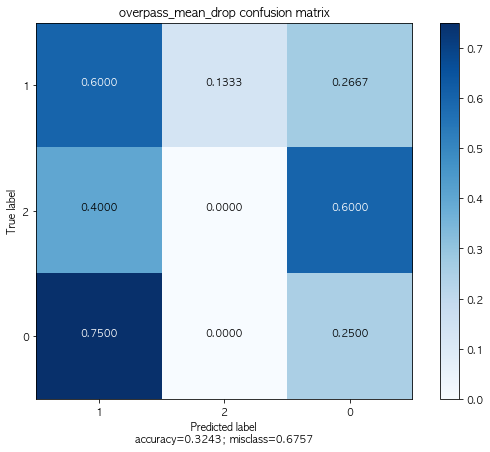

GridSearch 수행시간 :  36.46718692779541
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 1, 'min_split_loss': 4, 'n_estimators': 200}
정확도 :  0.40540540540540543
f1 score : [0.57692308 0.         0.        ]
f1 score average : 0.1923076923076923


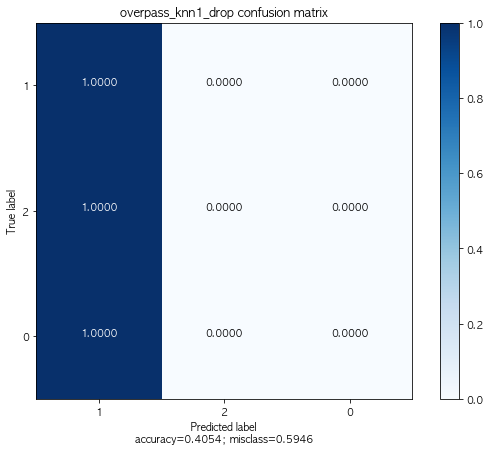

GridSearch 수행시간 :  44.024940967559814
최적 하이퍼 파라미터 : {'learning_rate': 0.001, 'max_depth': 5, 'min_split_loss': 1, 'n_estimators': 300}
정확도 :  0.5833333333333334
f1 score : [0.41176471 0.75       0.36363636]
f1 score average : 0.5084670231729055


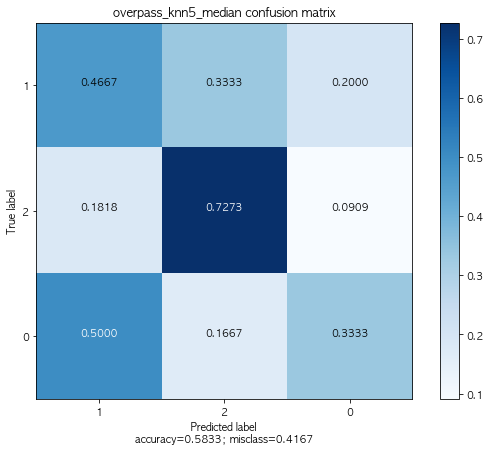

GridSearch 수행시간 :  43.054534912109375
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 5, 'min_split_loss': 4, 'n_estimators': 100}
정확도 :  0.6166666666666667
f1 score : [0.42424242 0.81355932 0.42857143]
f1 score average : 0.5554577249492504


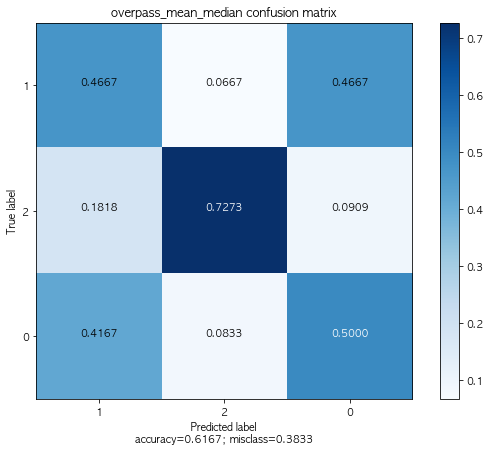

GridSearch 수행시간 :  43.242234230041504
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 1, 'min_split_loss': 6, 'n_estimators': 500}
정확도 :  0.6166666666666667
f1 score : [0.5106383  0.81967213 0.        ]
f1 score average : 0.44343680967329385


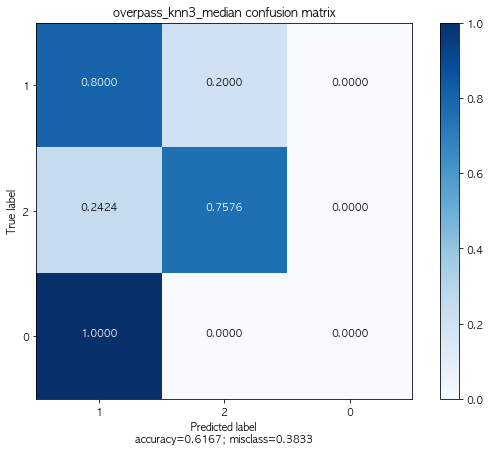

GridSearch 수행시간 :  36.78501796722412
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 1, 'min_split_loss': 3, 'n_estimators': 100}
정확도 :  0.35135135135135137
f1 score : [0.52173913 0.         0.11111111]
f1 score average : 0.21095008051529796


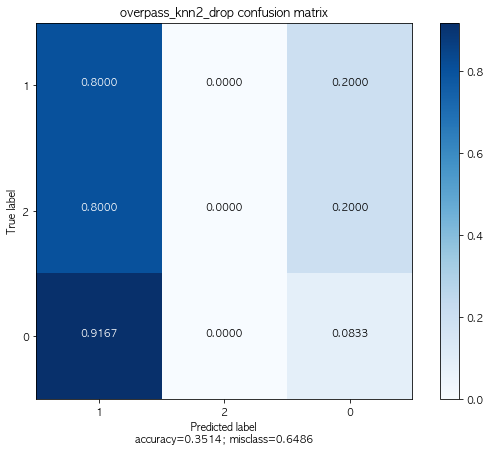

GridSearch 수행시간 :  39.45739817619324
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 5, 'min_split_loss': 2, 'n_estimators': 500}
정확도 :  0.21621621621621623
f1 score : [0.35       0.         0.10526316]
f1 score average : 0.15175438596491228


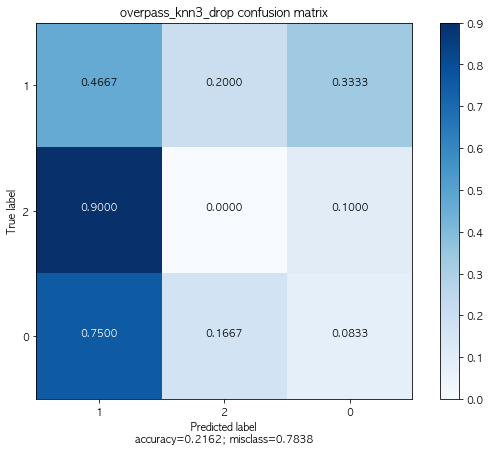

GridSearch 수행시간 :  38.149327993392944
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 3, 'min_split_loss': 3, 'n_estimators': 500}
정확도 :  0.32432432432432434
f1 score : [0.48979592 0.         0.        ]
f1 score average : 0.163265306122449


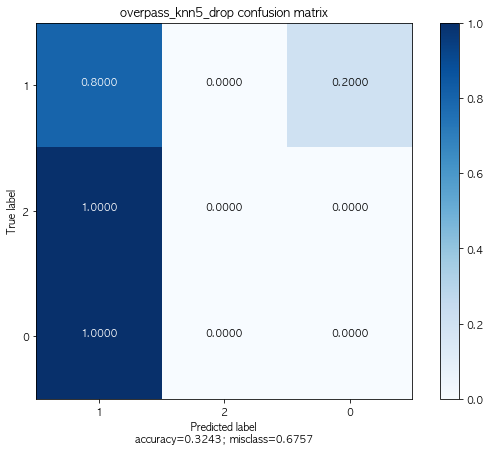

GridSearch 수행시간 :  36.355003118515015
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 1, 'min_split_loss': 4, 'n_estimators': 500}
정확도 :  0.40540540540540543
f1 score : [0.57692308 0.         0.        ]
f1 score average : 0.1923076923076923


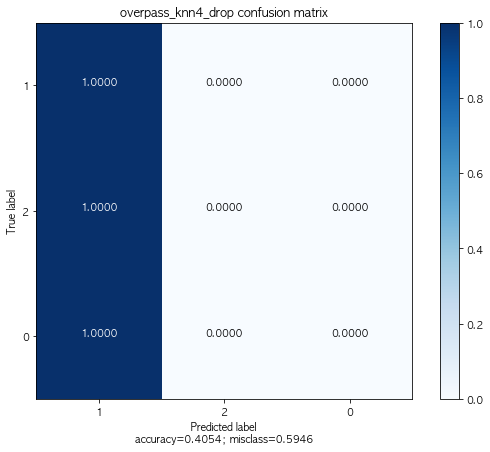

GridSearch 수행시간 :  42.34890699386597
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 3, 'min_split_loss': 2, 'n_estimators': 300}
정확도 :  0.65
f1 score : [0.53658537 0.78571429 0.52173913]
f1 score average : 0.614679594000909


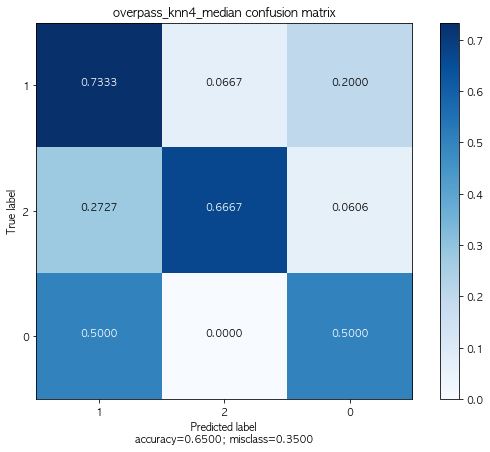

GridSearch 수행시간 :  96.12814903259277
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 1, 'min_split_loss': 5, 'n_estimators': 500}
정확도 :  0.5833333333333334
f1 score : [0.45454545 0.79365079 0.        ]
f1 score average : 0.4160654160654161


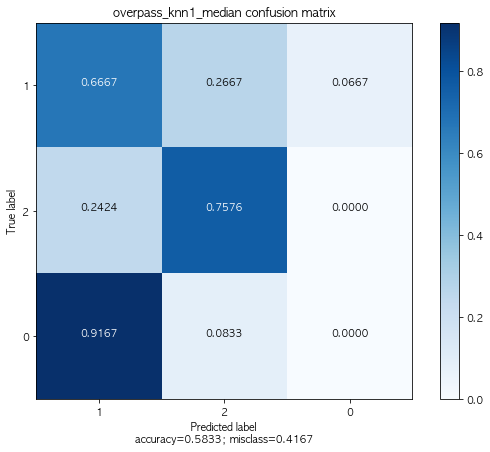

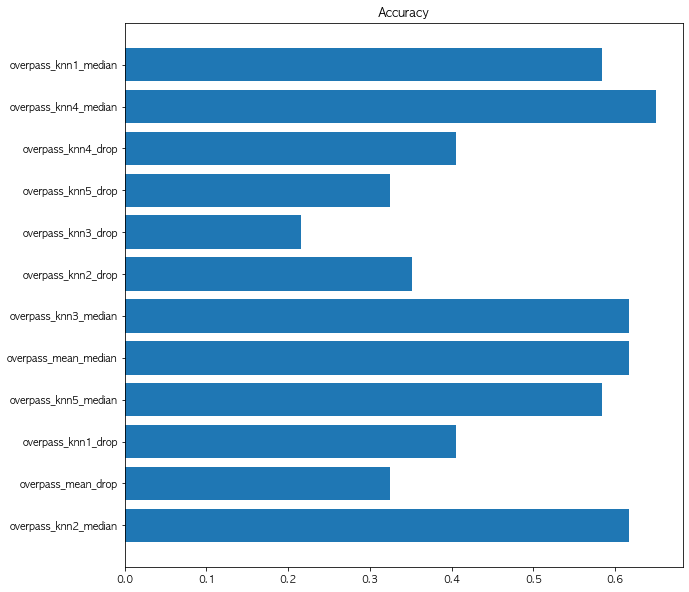

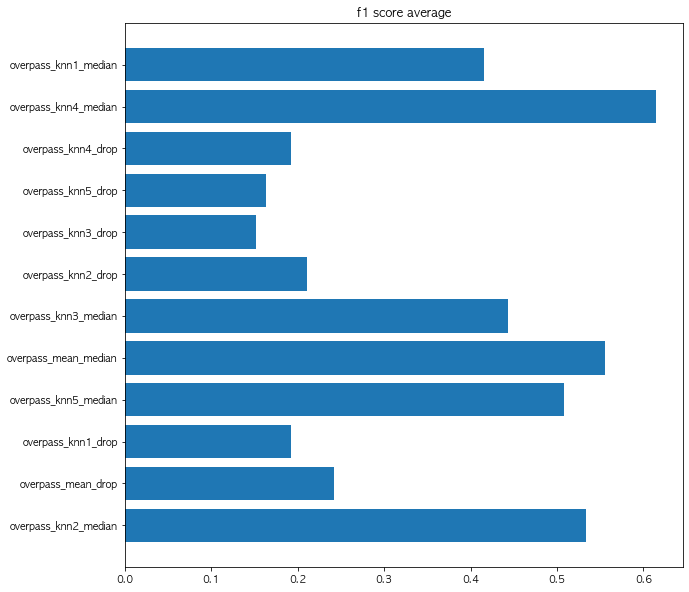

In [30]:
accuracy_li = []
f1_avg_li = []
filename_li = []

for case in overpass_list :
    df = pd.read_csv(case, encoding='cp949')
    name = case.split('/')[-1].split('.')[0]
    # print(df.columns)
    df = preprocess_df(df, drop_col=drop_col, labeling_col=onehot_col, scaling_col=scaling_col, scaling_func=StandardScaler)
    # print(df.columns)
    accuracy_li, f1_avg_li = xgboost_result(df, name, accuracy_li, f1_avg_li, optimizing=True)
    filename_li.append(name)

plt.figure(figsize=(10,10))
plt.barh(filename_li, accuracy_li)
plt.title("Accuracy")
plt.show()

plt.figure(figsize=(10,10))
plt.barh(filename_li, f1_avg_li)
plt.title("f1 score average")
plt.show()

# 터널형

GridSearch 수행시간 :  24.616275787353516
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 3, 'min_split_loss': 1, 'n_estimators': 100}
정확도 :  0.56
f1 score : [0.60869565 0.44444444 0.55555556]
f1 score average : 0.5362318840579711


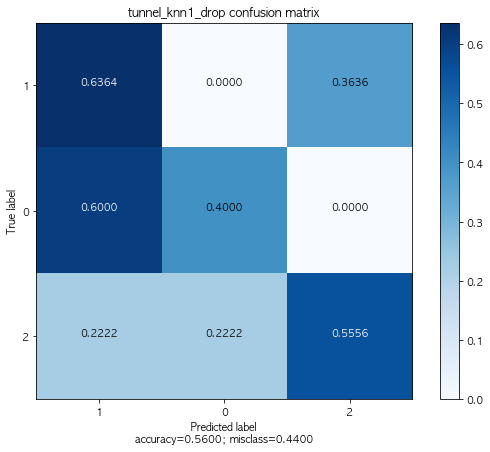

GridSearch 수행시간 :  26.306196928024292
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 7, 'min_split_loss': 1, 'n_estimators': 200}
정확도 :  0.64
f1 score : [0.7        0.5        0.66666667]
f1 score average : 0.6222222222222222


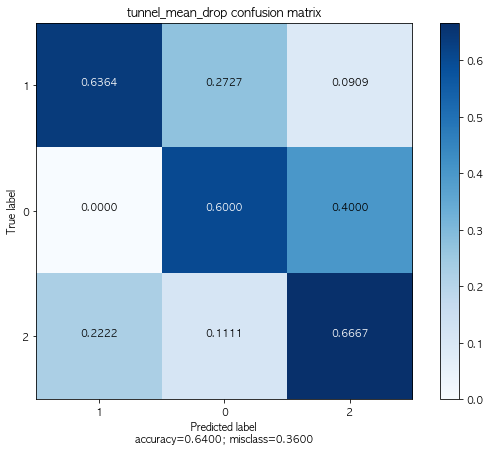

GridSearch 수행시간 :  29.555034160614014
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 3, 'min_split_loss': 1, 'n_estimators': 100}
정확도 :  0.675
f1 score : [0.5        0.78947368 0.63636364]
f1 score average : 0.6419457735247208


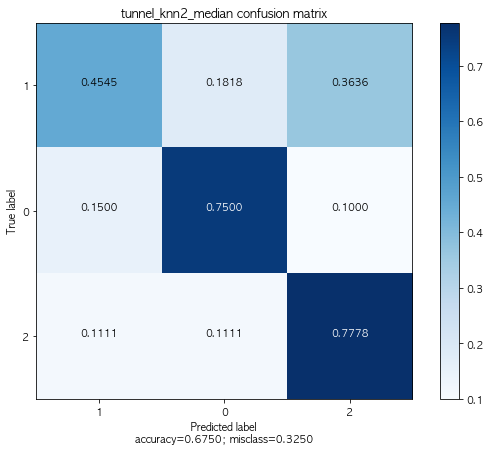

GridSearch 수행시간 :  28.784787893295288
최적 하이퍼 파라미터 : {'learning_rate': 0.001, 'max_depth': 1, 'min_split_loss': 1, 'n_estimators': 10}
정확도 :  0.725
f1 score : [0.52631579 0.88888889 0.64      ]
f1 score average : 0.6850682261208577


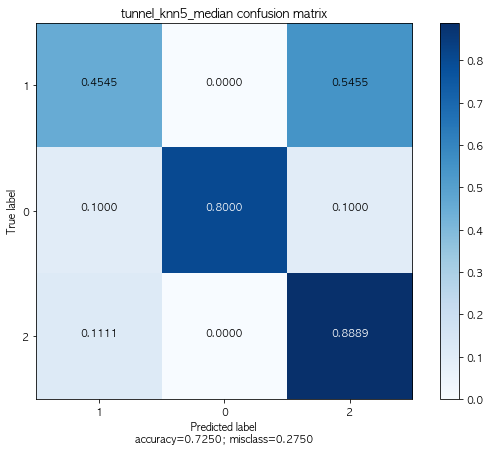

GridSearch 수행시간 :  30.53282117843628
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 3, 'min_split_loss': 1, 'n_estimators': 200}
정확도 :  0.75
f1 score : [0.69565217 0.8        0.72727273]
f1 score average : 0.7409749670619236


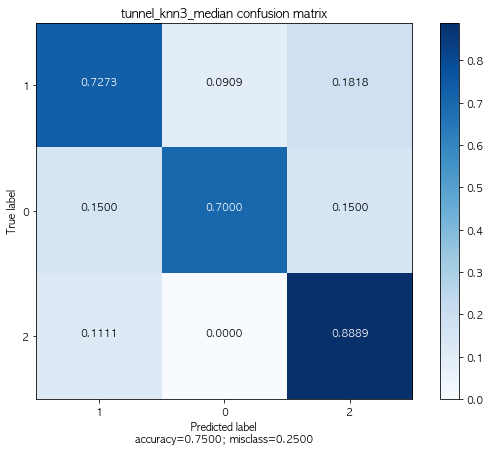

GridSearch 수행시간 :  25.670697927474976
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 7, 'min_split_loss': 2, 'n_estimators': 100}
정확도 :  0.56
f1 score : [0.66666667 0.         0.63157895]
f1 score average : 0.43274853801169594


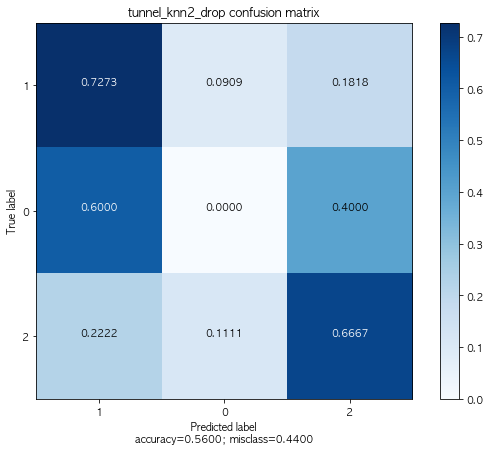

GridSearch 수행시간 :  28.85384702682495
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 5, 'min_split_loss': 1, 'n_estimators': 500}
정확도 :  0.64
f1 score : [0.64 0.   0.8 ]
f1 score average : 0.48


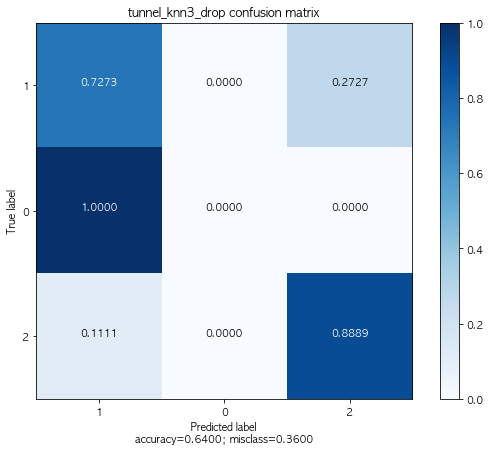

GridSearch 수행시간 :  31.78062915802002
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 5, 'min_split_loss': 1, 'n_estimators': 300}
정확도 :  0.8
f1 score : [0.66666667 0.97435897 0.6       ]
f1 score average : 0.747008547008547


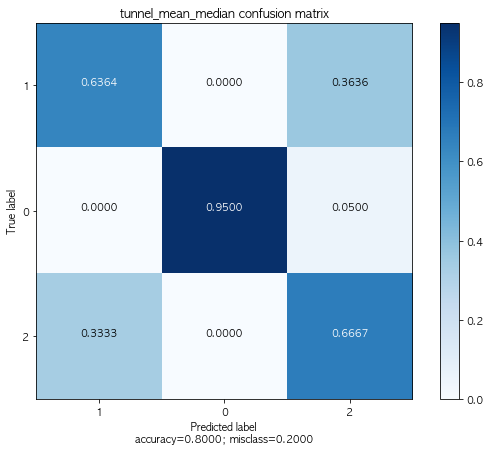

GridSearch 수행시간 :  29.89347195625305
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 3, 'min_split_loss': 3, 'n_estimators': 200}
정확도 :  0.675
f1 score : [0.5        0.82926829 0.52631579]
f1 score average : 0.618528027385537


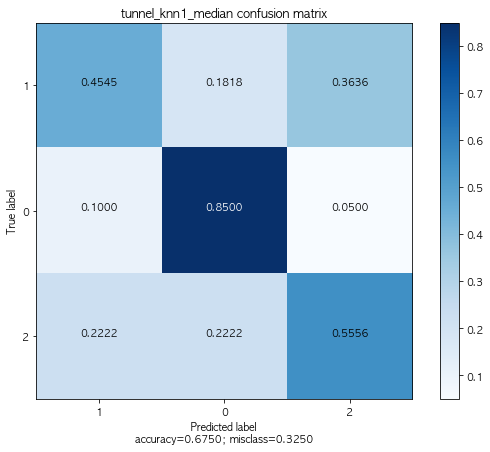

GridSearch 수행시간 :  30.676984071731567
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 1, 'min_split_loss': 1, 'n_estimators': 500}
정확도 :  0.75
f1 score : [0.55555556 0.89473684 0.66666667]
f1 score average : 0.7056530214424951


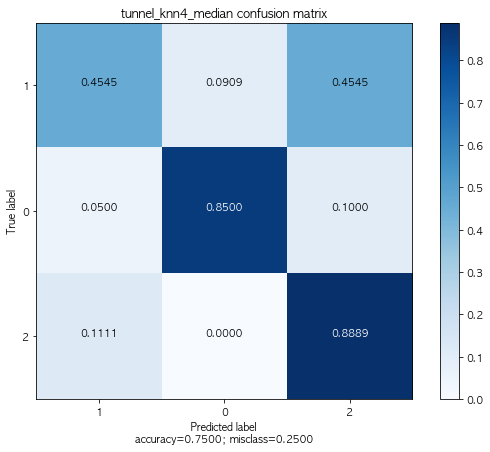

GridSearch 수행시간 :  24.277846813201904
최적 하이퍼 파라미터 : {'learning_rate': 0.01, 'max_depth': 1, 'min_split_loss': 4, 'n_estimators': 10}
정확도 :  0.44
f1 score : [0.5        0.         0.47058824]
f1 score average : 0.3235294117647059


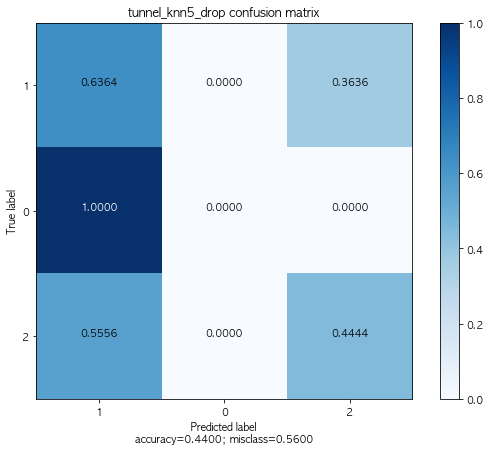

GridSearch 수행시간 :  26.1424298286438
최적 하이퍼 파라미터 : {'learning_rate': 0.001, 'max_depth': 5, 'min_split_loss': 3, 'n_estimators': 300}
정확도 :  0.56
f1 score : [0.55555556 0.         0.75      ]
f1 score average : 0.4351851851851851


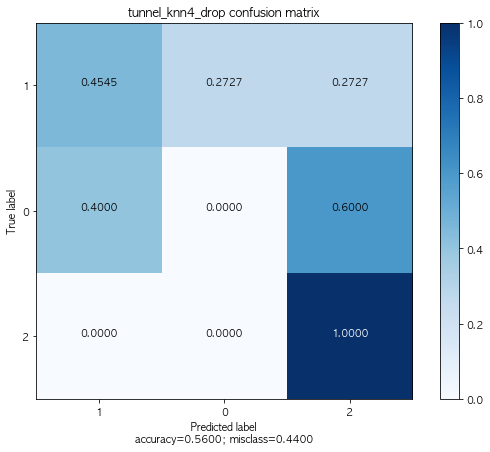

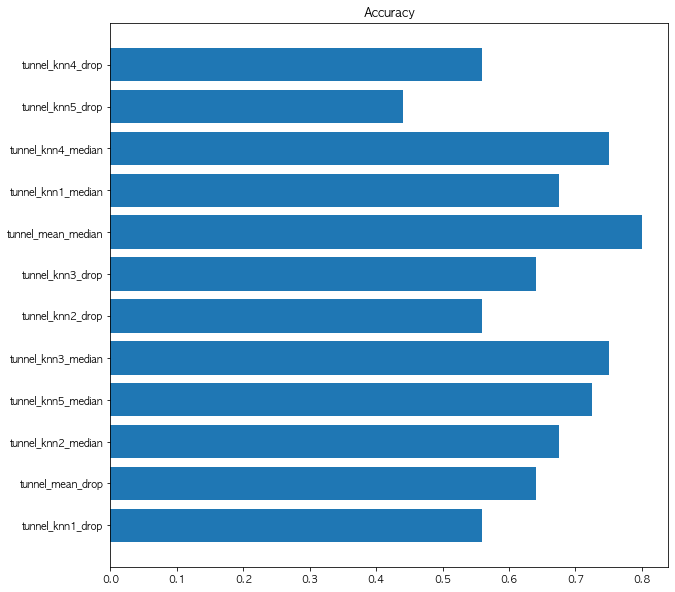

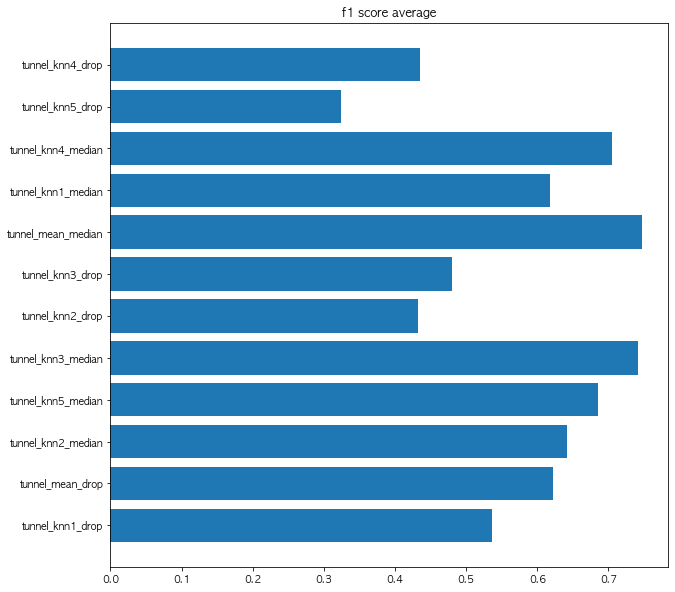

In [31]:
accuracy_li = []
f1_avg_li = []
filename_li = []

for case in tunnel_list :
    df = pd.read_csv(case, encoding='cp949')
    name = case.split('/')[-1].split('.')[0]
    # print(df.columns)
    df = preprocess_df(df, drop_col=drop_col, labeling_col=onehot_col, scaling_col=scaling_col_tunnel, scaling_func=StandardScaler)
    # print(df.columns)
    accuracy_li, f1_avg_li = xgboost_result(df, name, accuracy_li, f1_avg_li, optimizing=True)
    filename_li.append(name)

plt.figure(figsize=(10,10))
plt.barh(filename_li, accuracy_li)
plt.title("Accuracy")
plt.show()

plt.figure(figsize=(10,10))
plt.barh(filename_li, f1_avg_li)
plt.title("f1 score average")
plt.show()